# Forecasting

This is an example of how to use the Forecasting tool.

We perform forecasting on the Air Quality dataset.

In [1]:
import os
from pathlib import Path

In [2]:
BASE_URL = "http://127.0.0.1:8000"

In [3]:
import json

import httpx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
SYNTHEFY_PACKAGE_BASE = os.environ.get("SYNTHEFY_PACKAGE_BASE", "/home/synthefy/synthefy-package")

Setup Client

In [4]:
client = httpx.Client(base_url=BASE_URL, timeout=30.0)

Setup your input data for Forecasting

For Forecasting, both the meta-data conditions and the time-series data need to be passed in.

For reference, the time-series cols are as follows:

In [5]:
time_series_cols = [
    "PM2.5",
    "PM10",
    "SO2",
    "NO2",
    "CO",
    "O3"
]

The meta-data cols are divided into two categories: discrete and continuous.

Discrete:

In [6]:
discrete_cols = ["wd",]

Continuous:

In [7]:
continuous_cols = [
    "TEMP",
    "PRES",
    "DEWP",
    "RAIN",
    "WSPM"
]

There are also group_labels, which can be thought of as 'artificial' discrete conditions

In [8]:
group_labels = [
    "station",
]

The timestamp column in the raw data is also defined

In [9]:
timestamps_col = ["date_time",]

In my case, I'm going to get data from a csv I have handy.

In [10]:
air_quality_df = pd.read_csv(f"{SYNTHEFY_PACKAGE_BASE}/examples/air_quality_data_window.csv")
air_quality_df = air_quality_df.drop(columns=["Unnamed: 0",])  # a serial number implicity added by read_csv
air_quality_df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,date_time
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,31.0,63.0,17.0,61.0,700.0,53.0,10.9,1016.6,-10.6,0.0,SW,3.5,Aotizhongxin,2013-03-04 19:00:00
92,34.0,84.0,18.0,76.0,800.0,40.0,9.9,1016.9,-10.3,0.0,SSW,3.1,Aotizhongxin,2013-03-04 20:00:00
93,40.0,85.0,40.0,76.0,800.0,39.0,8.4,1016.9,-10.0,0.0,SSW,2.1,Aotizhongxin,2013-03-04 21:00:00
94,51.0,91.0,46.0,85.0,1000.0,31.0,8.6,1016.3,-9.9,0.0,SSW,2.4,Aotizhongxin,2013-03-04 22:00:00


In [11]:
air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PM2.5      96 non-null     float64
 1   PM10       96 non-null     float64
 2   SO2        95 non-null     float64
 3   NO2        95 non-null     float64
 4   CO         95 non-null     float64
 5   O3         96 non-null     float64
 6   TEMP       96 non-null     float64
 7   PRES       96 non-null     float64
 8   DEWP       96 non-null     float64
 9   RAIN       96 non-null     float64
 10  wd         96 non-null     object 
 11  WSPM       96 non-null     float64
 12  station    96 non-null     object 
 13  date_time  96 non-null     object 
dtypes: float64(11), object(3)
memory usage: 10.6+ KB


You can also setup your own df and populate it

In [12]:
air_quality_df_dtypes = air_quality_df.dtypes

In [13]:
empty_air_quality_df = pd.DataFrame({col: pd.Series(dtype=dt) for col, dt in air_quality_df_dtypes.items()})

In [14]:
empty_air_quality_df["PM2.5"] = 4.0
empty_air_quality_df["PM10"] = 4.0
empty_air_quality_df["SO2"] = 4.0
empty_air_quality_df["NO2"] = 7.0
empty_air_quality_df["CO"] = 300.0
empty_air_quality_df["O3"] = 77.0
empty_air_quality_df['TEMP'] = 1.1
empty_air_quality_df['PRES'] = 1023.2
empty_air_quality_df['DEWP'] = -18.2
empty_air_quality_df['RAIN'] = 0.0
empty_air_quality_df['wd'] = "NNW"
empty_air_quality_df['WSPM'] = 5.6
empty_air_quality_df['station'] = "Aotizhongxin"

Convert the df to a json

In [15]:
columns_to_check = ["SO2", "NO2", "CO"]
null_counts = air_quality_df[columns_to_check].isnull().sum()
null_counts

SO2    1
NO2    1
CO     1
dtype: int64

In [16]:
# Fill Null Values
air_quality_df = air_quality_df.fillna(method='ffill')

/tmp/ipykernel_1031498/3619237480.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  air_quality_df = air_quality_df.fillna(method='ffill')


In [17]:
json_data_for_stream = air_quality_df.to_json()
json_data_for_stream

'{"PM2.5":{"0":4.0,"1":8.0,"2":7.0,"3":6.0,"4":3.0,"5":5.0,"6":3.0,"7":3.0,"8":3.0,"9":3.0,"10":3.0,"11":3.0,"12":3.0,"13":3.0,"14":6.0,"15":8.0,"16":9.0,"17":10.0,"18":11.0,"19":8.0,"20":11.0,"21":12.0,"22":15.0,"23":24.0,"24":22.0,"25":14.0,"26":13.0,"27":3.0,"28":3.0,"29":9.0,"30":4.0,"31":3.0,"32":3.0,"33":10.0,"34":11.0,"35":18.0,"36":26.0,"37":25.0,"38":26.0,"39":37.0,"40":37.0,"41":44.0,"42":54.0,"43":61.0,"44":67.0,"45":74.0,"46":81.0,"47":93.0,"48":112.0,"49":109.0,"50":110.0,"51":105.0,"52":106.0,"53":101.0,"54":91.0,"55":79.0,"56":77.0,"57":83.0,"58":94.0,"59":96.0,"60":91.0,"61":98.0,"62":72.0,"63":48.0,"64":28.0,"65":26.0,"66":24.0,"67":19.0,"68":60.0,"69":117.0,"70":54.0,"71":46.0,"72":42.0,"73":49.0,"74":34.0,"75":12.0,"76":7.0,"77":10.0,"78":13.0,"79":14.0,"80":13.0,"81":15.0,"82":16.0,"83":18.0,"84":13.0,"85":3.0,"86":3.0,"87":10.0,"88":14.0,"89":20.0,"90":25.0,"91":31.0,"92":34.0,"93":40.0,"94":51.0,"95":58.0},"PM10":{"0":4.0,"1":8.0,"2":7.0,"3":6.0,"4":3.0,"5":5.0,"6

Now query the API

In [18]:
stream_synthesis_response = client.post(
    "/api/forecast/air_quality/stream", json=json.loads(json_data_for_stream)
)

Examine the response

In [19]:
if stream_synthesis_response.status_code != 200:
    print(f"Error: {stream_synthesis_response.text}")
else:
    print(f"Success: Code={stream_synthesis_response.status_code}\n")

Success: Code=200



We now have a response object.

In [20]:
stream_synthesis_response.json()

{'PM10_synthetic': {'0': 7.0,
  '1': 14.0,
  '2': 19.0,
  '3': 29.0,
  '4': 30.0,
  '5': 33.0,
  '6': 35.0,
  '7': 40.0,
  '8': 46.0,
  '9': 58.0,
  '10': 79.0,
  '11': 86.0,
  '12': 96.0,
  '13': 103.0,
  '14': 113.0,
  '15': 120.0,
  '16': 130.0,
  '17': 132.0,
  '18': 132.0,
  '19': 129.0,
  '20': 136.0,
  '21': 135.0,
  '22': 142.0,
  '23': 116.0,
  '24': 110.0,
  '25': 119.0,
  '26': 122.0,
  '27': 117.0,
  '28': 108.0,
  '29': 134.0,
  '30': 106.0,
  '31': 114.0,
  '32': 100.0,
  '33': 103.0,
  '34': 82.0,
  '35': 71.0,
  '36': 175.0,
  '37': 181.0,
  '38': 105.0,
  '39': 94.0,
  '40': 83.0,
  '41': 80.0,
  '42': 62.0,
  '43': 34.0,
  '44': 18.0,
  '45': 24.0,
  '46': 32.0,
  '47': 36.0,
  '48': 35.0,
  '49': 32.0,
  '50': 24.0,
  '51': 33.0,
  '52': 28.0,
  '53': 12.0,
  '54': 10.0,
  '55': 13.0,
  '56': 20.0,
  '57': 33.0,
  '58': 44.0,
  '59': 63.0,
  '60': 84.0,
  '61': 85.0,
  '62': 91.0,
  '63': 94.0,
  '64': 106.23578643798828,
  '65': 110.9666748046875,
  '66': 95.7909545

Let's try it again, this time by changing the wind direction in the data to always be "NNW"

In [21]:
air_quality_df['wd'] = "NNW"

Make the Query

In [22]:
stream_synthesis_response = client.post(
    "/api/forecast/air_quality/stream", json=json.loads(air_quality_df.to_json())
)
if stream_synthesis_response.status_code != 200:
    print(f"Error: {stream_synthesis_response.text}")
else:
    print(f"Success: Code={stream_synthesis_response.status_code}\n")

Success: Code=200



Visualize the results; only the time-series columns are returned

In [23]:
df = pd.read_json(json.dumps(stream_synthesis_response.json()))
df.info(); df

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 95
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   PM10_synthetic   96 non-null     float64       
 1   date_time        96 non-null     datetime64[ns]
 2   SO2_synthetic    96 non-null     float64       
 3   PM2.5_synthetic  96 non-null     float64       
 4   NO2_synthetic    96 non-null     float64       
 5   O3_synthetic     96 non-null     float64       
 6   CO_synthetic     96 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 6.0 KB


/tmp/ipykernel_1031498/3751782356.py:1: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(json.dumps(stream_synthesis_response.json()))


,PM10_synthetic,date_time,SO2_synthetic,PM2.5_synthetic,NO2_synthetic,O3_synthetic,CO_synthetic
0,7.000000,2013-03-02 08:00:00,21.000000,3.000000,49.000000,43.000000,500.000000
1,14.000000,2013-03-02 09:00:00,47.000000,10.000000,62.000000,29.000000,700.000000
2,19.000000,2013-03-02 10:00:00,36.000000,11.000000,60.000000,34.000000,600.000000
3,29.000000,2013-03-02 11:00:00,36.000000,18.000000,70.000000,27.000000,800.000000
4,30.000000,2013-03-02 12:00:00,25.000000,26.000000,76.000000,22.000000,900.000000
...,...,...,...,...,...,...,...
91,115.210876,2013-03-06 03:00:00,44.512924,67.588707,62.253220,74.121452,1221.041138
92,98.487495,2013-03-06 04:00:00,37.684631,55.605614,50.776848,76.148857,1110.243042
93,84.585640,2013-03-06 05:00:00,32.853275,43.491455,45.187912,73.987930,919.203918
94,75.652832,2013-03-06 06:00:00,28.017738,35.984932,42.654541,71.031052,829.104492


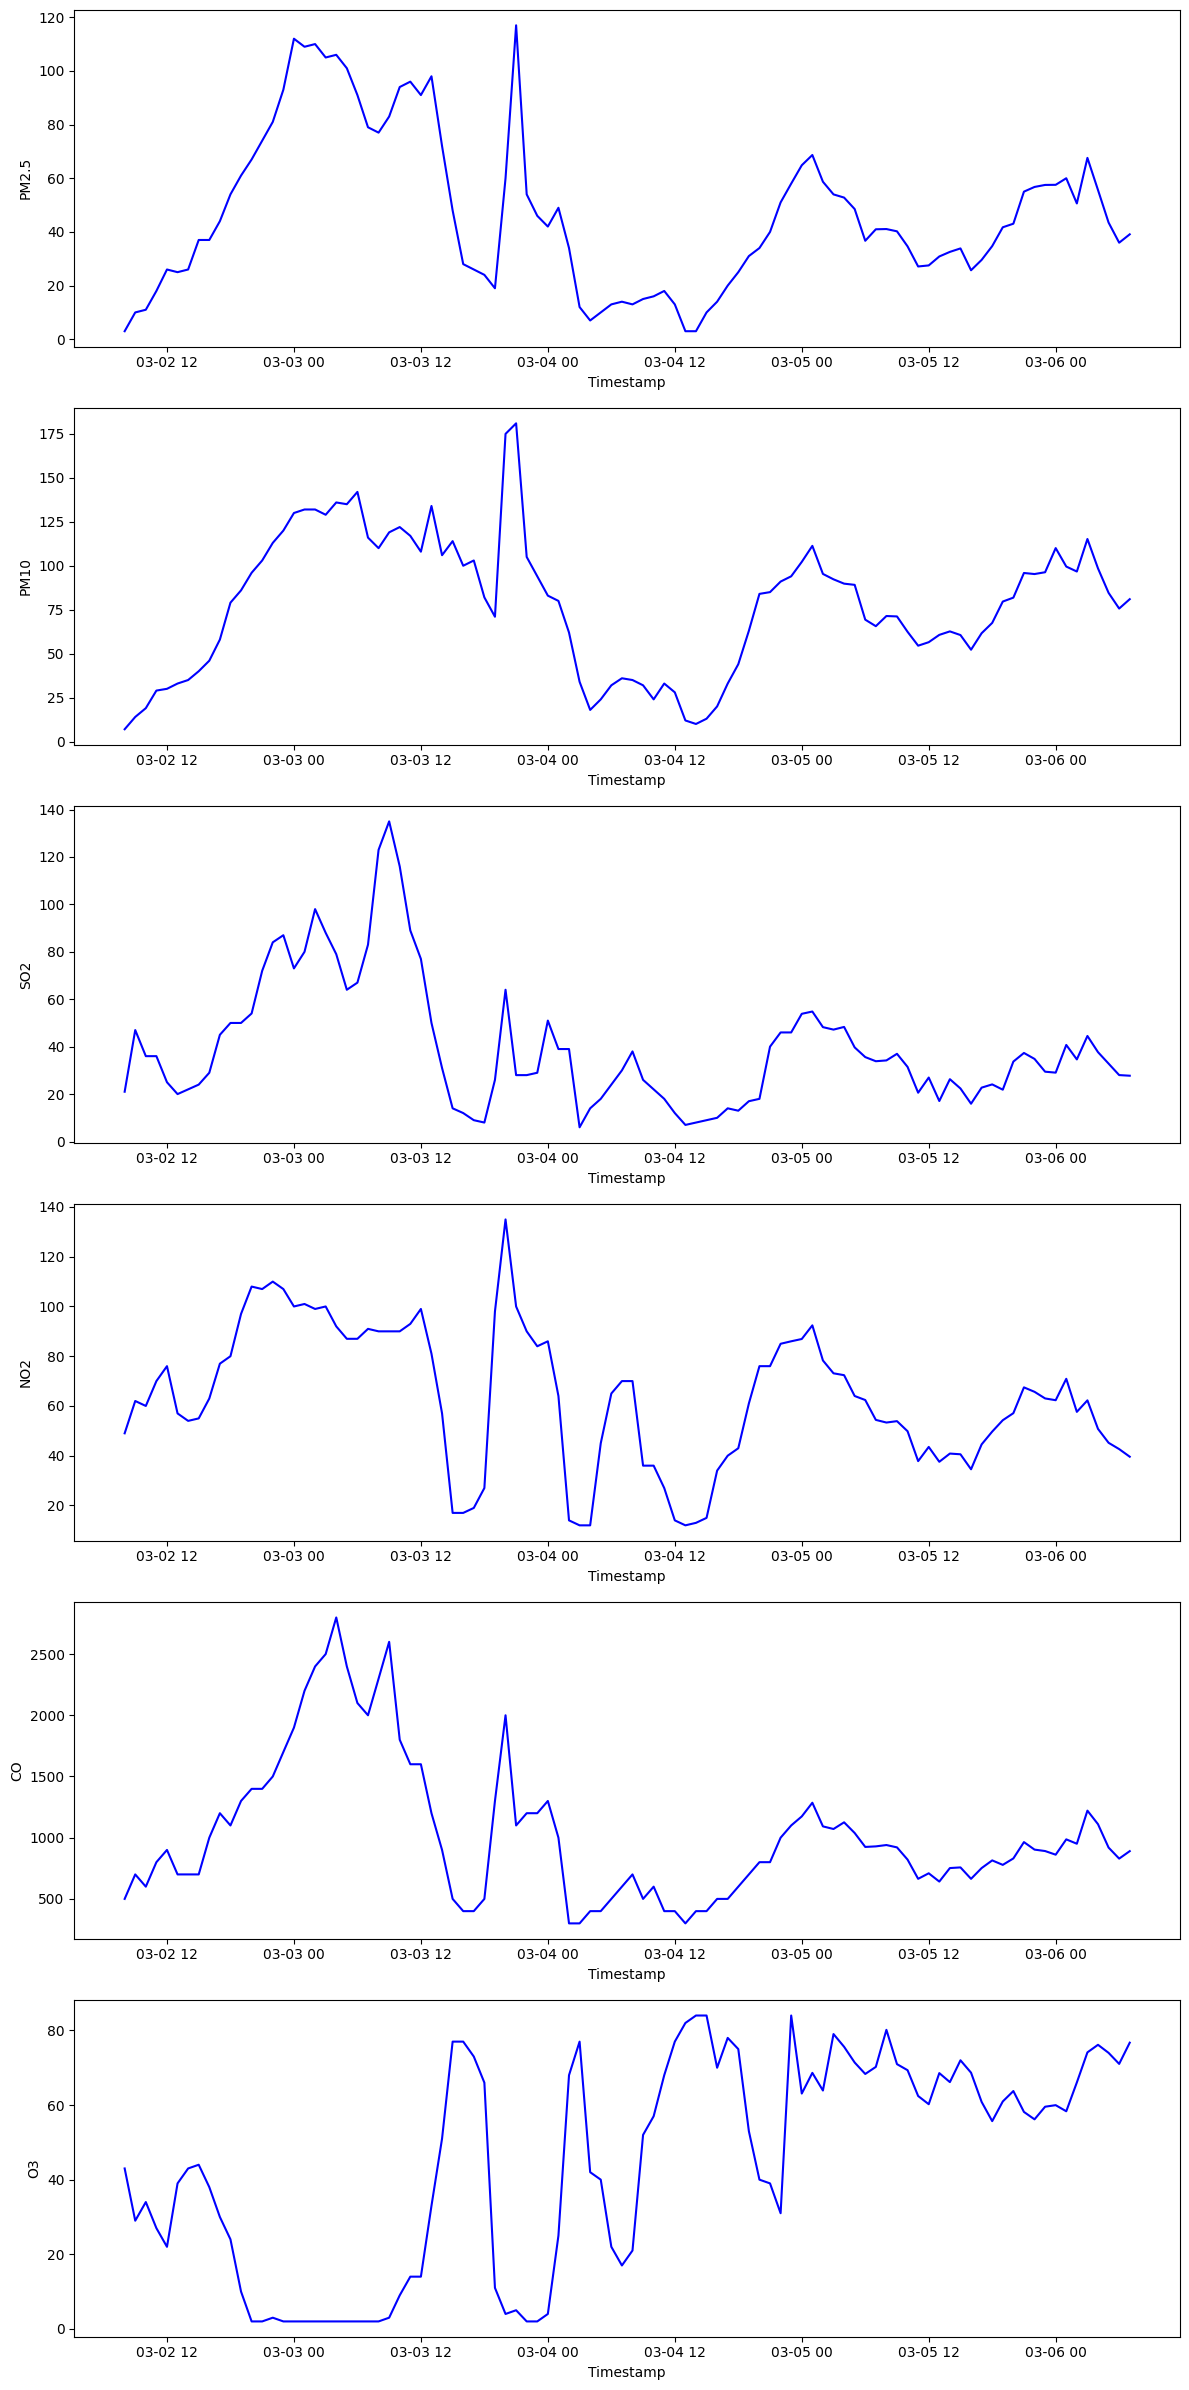

In [24]:
# Create a subplot for each timeseries
fig, axes = plt.subplots(
    len(time_series_cols), 1, figsize=(12, 4 * len(time_series_cols))
)

for idx, time_series_col in enumerate(time_series_cols):
    # Plot time series
    axes[idx].plot(df[timestamps_col], df[f"{time_series_col}_forecast"], "b-")

    # Set labels
    axes[idx].set_xlabel("Timestamp")
    axes[idx].set_ylabel(time_series_col)

plt.tight_layout()